# Python and Neo4j for Network Science

In this notebook we'll look at how to combine Python and Neo4j to explore a network/graph containing interactions between Game of Thrones characters.

In [35]:
from neo4j.v1 import GraphDatabase, basic_auth
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo"))

## Import data

In [37]:
with driver.session() as session:
    session.run("CREATE CONSTRAINT ON (c:Character) ASSERT c.name IS UNIQUE")
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book1-edges.csv" AS row
    MERGE (src:Character {name: row.Source})
    MERGE (tgt:Character {name: row.Target})
    // relationship for the book
    MERGE (src)-[r:INTERACTS1]->(tgt)
    ON CREATE SET r.weight = toInt(row.weight), r.book=1
    """)
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book2-edges.csv" AS row
    MERGE (src:Character {name: row.Source})
    MERGE (tgt:Character {name: row.Target})
    // relationship for the book
    MERGE (src)-[r:INTERACTS2]->(tgt)
    ON CREATE SET r.weight = toInt(row.weight), r.book=2
    """)    
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book3-edges.csv" AS row
    MERGE (src:Character {name: row.Source})
    MERGE (tgt:Character {name: row.Target})
    // relationship for the book
    MERGE (src)-[r:INTERACTS3]->(tgt)
    ON CREATE SET r.weight = toInt(row.weight), r.book=3
    """) 
    print(result.summary().counters)
    
    result = session.run("""\
    LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book45-edges.csv" AS row
    MERGE (src:Character {name: row.Source})
    MERGE (tgt:Character {name: row.Target})
    // relationship for the book
    MERGE (src)-[r:INTERACTS45]->(tgt)
    ON CREATE SET r.weight = toInt(row.weight), r.book=45
    """)     
    print(result.summary().counters)

{'labels_added': 187, 'relationships_created': 684, 'nodes_created': 187, 'properties_set': 1555}
{'labels_added': 169, 'relationships_created': 775, 'nodes_created': 169, 'properties_set': 1719}
{'labels_added': 142, 'relationships_created': 1008, 'nodes_created': 142, 'properties_set': 2158}
{'labels_added': 298, 'relationships_created': 1329, 'nodes_created': 298, 'properties_set': 2956}


## How many characters do we have?

To get started let's run the query which calculates the number of characters in Game of Thrones and print it to the screen.

In [38]:
query = """\
MATCH (c:Character)
RETURN count(c) AS totalCharacters
"""

with driver.session() as session:
    result = session.run(query)
    row = result.peek()
    print("Number of characters: {0}".format(row["totalCharacters"]))        

Number of characters: 796


## What's the distribution of interactions by characters? 

We can combine Neo4j and matplotlib to create a histogram that shows how interactions are spread out across our characters.

In [39]:
query = """\
MATCH (c:Character)--()
RETURN c, count(*) AS numberOfInteractions
"""

with driver.session() as session:
    result = session.run(query)
    interactions = [row["numberOfInteractions"] for row in result]        

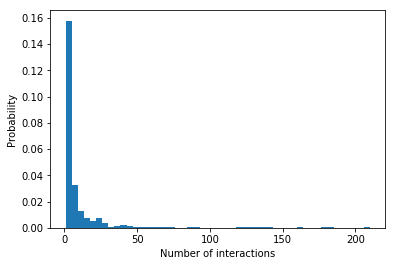

In [40]:
plt.hist(interactions, normed=True, bins=50)
plt.ylabel('Probability');
plt.xlabel('Number of interactions');
plt.show()

Unsurprisingly the majority of characters don't say much! This looks like a classic long tail/power law chart.

## Summary Statistics

We can calculate summary statistics on the interactions of characters:

In [41]:
query = """\
MATCH (c:Character)-->()
WITH c, count(*) AS num
RETURN min(num) AS min, max(num) AS max, avg(num) AS avg_characters, stdev(num) AS stdev
"""

with driver.session() as session:
    result = session.run(query)
    print(result.peek())

<Record min=1 max=148 avg_characters=6.578856152513001 stdev=14.16045587171888>


We can run the following query to calculate those statistics on a book by book basis:

In [42]:
query = """\
MATCH (c:Character)-[r]->()
WITH r.book as book, c, count(*) AS num
RETURN book, min(num) AS min, max(num) AS max, avg(num) AS avg_characters, stdev(num) AS stdev
ORDER BY book
"""

with driver.session() as session:
    result = session.run(query)
    for row in result:
        print(row)

<Record book=1 min=1 max=51 avg_characters=4.920863309352515 stdev=7.0967074915280755>
<Record book=2 min=1 max=37 avg_characters=4.015544041450779 stdev=5.360422756122164>
<Record book=3 min=1 max=36 avg_characters=4.289361702127663 stdev=5.335866147079831>
<Record book=45 min=1 max=57 avg_characters=3.691666666666668 stdev=5.636326417753424>


## Pivotal nodes

A node is said to be pivotal if it lies on all shortest paths between two other nodes in the network. We can find all pivotal nodes in the network.

The following query will find all the pivotal nodes in the network for the first book:

In [43]:
query = """\
MATCH (a:Character), (b:Character) WHERE id(a) > id(b)
MATCH p = allShortestPaths((a)-[:INTERACTS1*]-(b))

WITH collect(p) AS paths, a, b
UNWIND nodes(head(paths)) as c // first path

WITH *
WHERE NOT c IN [a,b]
AND all(path IN tail(paths) WHERE c IN nodes(path))

RETURN a.name, b.name, c.name AS PivotalNode, length(head(paths)) AS pathLength, length(paths) AS pathCount
SKIP 490
LIMIT 10
"""

with driver.session() as session:
    result = session.run(query)
    for row in result:
        print(row)

<Record a.name='Eroeh' b.name='Rickard-Karstark' PivotalNode='Eddard-Stark' pathLength=3 pathCount=1>
<Record a.name='Eroeh' b.name='Dywen' PivotalNode='Daenerys-Targaryen' pathLength=4 pathCount=2>
<Record a.name='Eroeh' b.name='Dywen' PivotalNode='Jon-Snow' pathLength=4 pathCount=2>
<Record a.name='Pypar' b.name='Kevan-Lannister' PivotalNode='Tyrion-Lannister' pathLength=3 pathCount=2>
<Record a.name='Daryn-Hornwood' b.name='Catelyn-Stark' PivotalNode='Eddard-Stark' pathLength=2 pathCount=1>
<Record a.name='Clydas' b.name='Gared' PivotalNode='Aemon-Targaryen-(Maester-Aemon)' pathLength=3 pathCount=1>
<Record a.name='Clydas' b.name='Gared' PivotalNode='Jeor-Mormont' pathLength=3 pathCount=1>
<Record a.name='Rickon-Stark' b.name='Gared' PivotalNode='Jeor-Mormont' pathLength=3 pathCount=3>
<Record a.name='Ogo' b.name='Myrcella-Baratheon' PivotalNode='Drogo' pathLength=3 pathCount=1>
<Record a.name='Ogo' b.name='Myrcella-Baratheon' PivotalNode='Robert-Baratheon' pathLength=3 pathCount=1>

## Querying with Pandas

We can take the results of Cypher queries and do further processing using the Pandas library.

For example here we find the first 5 rows using the Pandas `head()` function

In [44]:
query = """\
match (c:Character) 
return c.name AS name, size((c)--()) AS interactions
"""

with driver.session() as session:
    result = session.run(query)

df = pd.DataFrame([dict(record) for record in result])
print(df.head())

   interactions             name
0             7           Todder
1             1          Matthar
2             1            Othor
3             8   Paxter-Redwyne
4             1  Ulf-son-of-Umar


We could do our filtering using Pandas as well. The following code finds some of the characters who have more than 5 different interactions:

df.query('interactions>5').head()

We can find the characters with the least interactions as well:

In [45]:
df.query('1 < interactions <5').sort_values(by=["interactions"], ascending = True).head()

,interactions,name
5,2,Aegon-V-Targaryen
279,2,Smiling-Knight
535,2,Wick-Whittlestick
285,2,Oznak-zo-Pahl
287,2,Robin-Ryger


We could analyse the pivotal nodes query from earlier as well:

In [46]:
query = """\
MATCH (a:Character), (b:Character) WHERE id(a) > id(b)
MATCH p = allShortestPaths((a)-[:INTERACTS1*]-(b))

WITH collect(p) AS paths, a, b
UNWIND nodes(head(paths)) as c // first path

WITH *
WHERE NOT c IN [a,b]
AND all(path IN tail(paths) WHERE c IN nodes(path))

RETURN a.name AS p1, b.name AS p2, c.name AS PivotalNode, length(head(paths)) AS pathLength, length(paths) AS pathCount
"""

with driver.session() as session:
    result = session.run(query)

df = pd.DataFrame([dict(record) for record in result])
print(df.head())

        PivotalNode            p1             p2  pathCount  pathLength
0             Drogo  Rickon-Stark           Fogo          9           5
1               Ogo  Rickon-Stark           Fogo          9           5
2     Samwell-Tarly   Wyl-(guard)  Randyll-Tarly          5           4
3        Bran-Stark          Hali         Shagga          1           3
4  Tyrion-Lannister          Hali         Shagga          1           3


In [47]:
df.groupby(['PivotalNode']).mean().sort_values(by=["pathLength"], ascending=False).head()

,pathCount,pathLength
PivotalNode,,
Danwell-Frey,5.608696,4.777174
Ogo,2.043243,4.627027
Mace-Tyrell,5.632432,4.508108
Walder-Frey,5.633880,4.459016
Karyl-Vance,5.470270,4.448649
